<a href="https://colab.research.google.com/github/Annie-blare/WSL-FINALCODE/blob/main/VECTOR_CAPABILITIES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def perform_analysis(file_path, factor, Capability_Vector, perturbations):
    # Load the dataset
    data = pd.read_csv(file_path)

    # Calculate slopes and intercepts for each component of Capability_Vector
    slopes = {}
    intercepts = {}
    for col in Capability_Vector:
        X = data[[factor]]
        y = data[col]

        X_with_const = sm.add_constant(X)
        model = sm.OLS(y, X_with_const).fit()
        slopes[col] = model.params.get(factor, 0)  # Default to 0 if not found
        intercepts[col] = model.params.get('const', 0)  # Default to 0 if 'const' not found

    results = []
    for district_name in data['District'].unique():
        district_data = data[data['District'] == district_name]

        # Iterate through each perturbation level
        for p in perturbations:
            perturbation_ratio = p / 100.0
            cv_old = []
            cv_new = []
            impact_percent = []

            for col in Capability_Vector:
                perturbed_factor_value = district_data[factor] * (1 + perturbation_ratio)
                cv_old_val = slopes[col] * district_data[factor] + intercepts[col]
                cv_new_val = slopes[col] * perturbed_factor_value + intercepts[col]

                # Calculate percentage impact, handle division by zero
                impact = ((cv_new_val - cv_old_val) / cv_old_val.replace(0, np.nan)) * 100

                cv_old.append(cv_old_val.values[0] if not cv_old_val.empty else 0)
                cv_new.append(cv_new_val.values[0] if not cv_new_val.empty else 0)
                impact_percent.append(impact.values[0] if not impact.empty else 0)

            change = [new - old for new, old in zip(cv_new, cv_old)]
            scalarized_impact = np.linalg.norm(change) / np.linalg.norm(cv_old[:3])

            results.append({
                'District': district_name,
                'Perturbation (%)': p,
                # 'Rice_Production (old)': cv_old[0],
                # 'Maize_Production (old)': cv_old[1],
                # 'Jowar_Yield (old)': cv_old[2],
                # 'Rice_Production (new)': cv_new[0],
                # 'Maize_Production (new)': cv_new[1],
                # 'Jowar_Yield (new)': cv_new[2],
                'cv_old': cv_old[:3],
                'cv_new': cv_new[:3],
                'Change': change,
                'Impact (%)': impact_percent,
                'Scalarized_impact': scalarized_impact
            })

    results_df = pd.DataFrame(results)

    return results_df

# Adjust file_path, factor, Capability_Vector, and user_perturbations as needed
file_path = '/content/Agriculture_KAG_2016_17.csv'  # Ensure this is correctly set
factor = 'TotalNPK'
Capability_Vector = ['Rice_Production', 'Maize_Production', 'Jowar_Yield']
user_perturbations = [-20, -10, 10, 20]  # Example perturbations in percentages

results_df = perform_analysis(file_path, factor, Capability_Vector, user_perturbations)

# Print results (adjust printing as needed)
for district_name in results_df['District'].unique():
    district_table = results_df[results_df['District'] == district_name].reset_index(drop=True)
    print(f"Table for {district_name}:")
    print(district_table.head(4).to_string(index=False))
    print()


Table for BENGALURU:
 District  Perturbation (%)                                                     cv_old                                                    cv_new                                                         Change                                                    Impact (%)  Scalarized_impact
BENGALURU               -20 [62993.32893901956, 60346.246186831464, 593.2911885630076] [52021.94839499796, 48389.47333472854, 547.5374307133687] [-10971.380544021595, -11956.772852102928, -45.75375784963887] [-17.416734007885815, -19.813614943148014, -7.71185527977546]            0.18602
BENGALURU               -10 [62993.32893901956, 60346.246186831464, 593.2911885630076]    [57507.63866700875, 54367.85976078, 570.4143096381882]   [-5485.690272010805, -5978.386426051467, -22.87687892481938]   [-8.708367003942918, -9.906807471574012, -3.85592763988772]            0.09301
BENGALURU                10 [62993.32893901956, 60346.246186831464, 593.2911885630076] [68479.01921103036, 66324

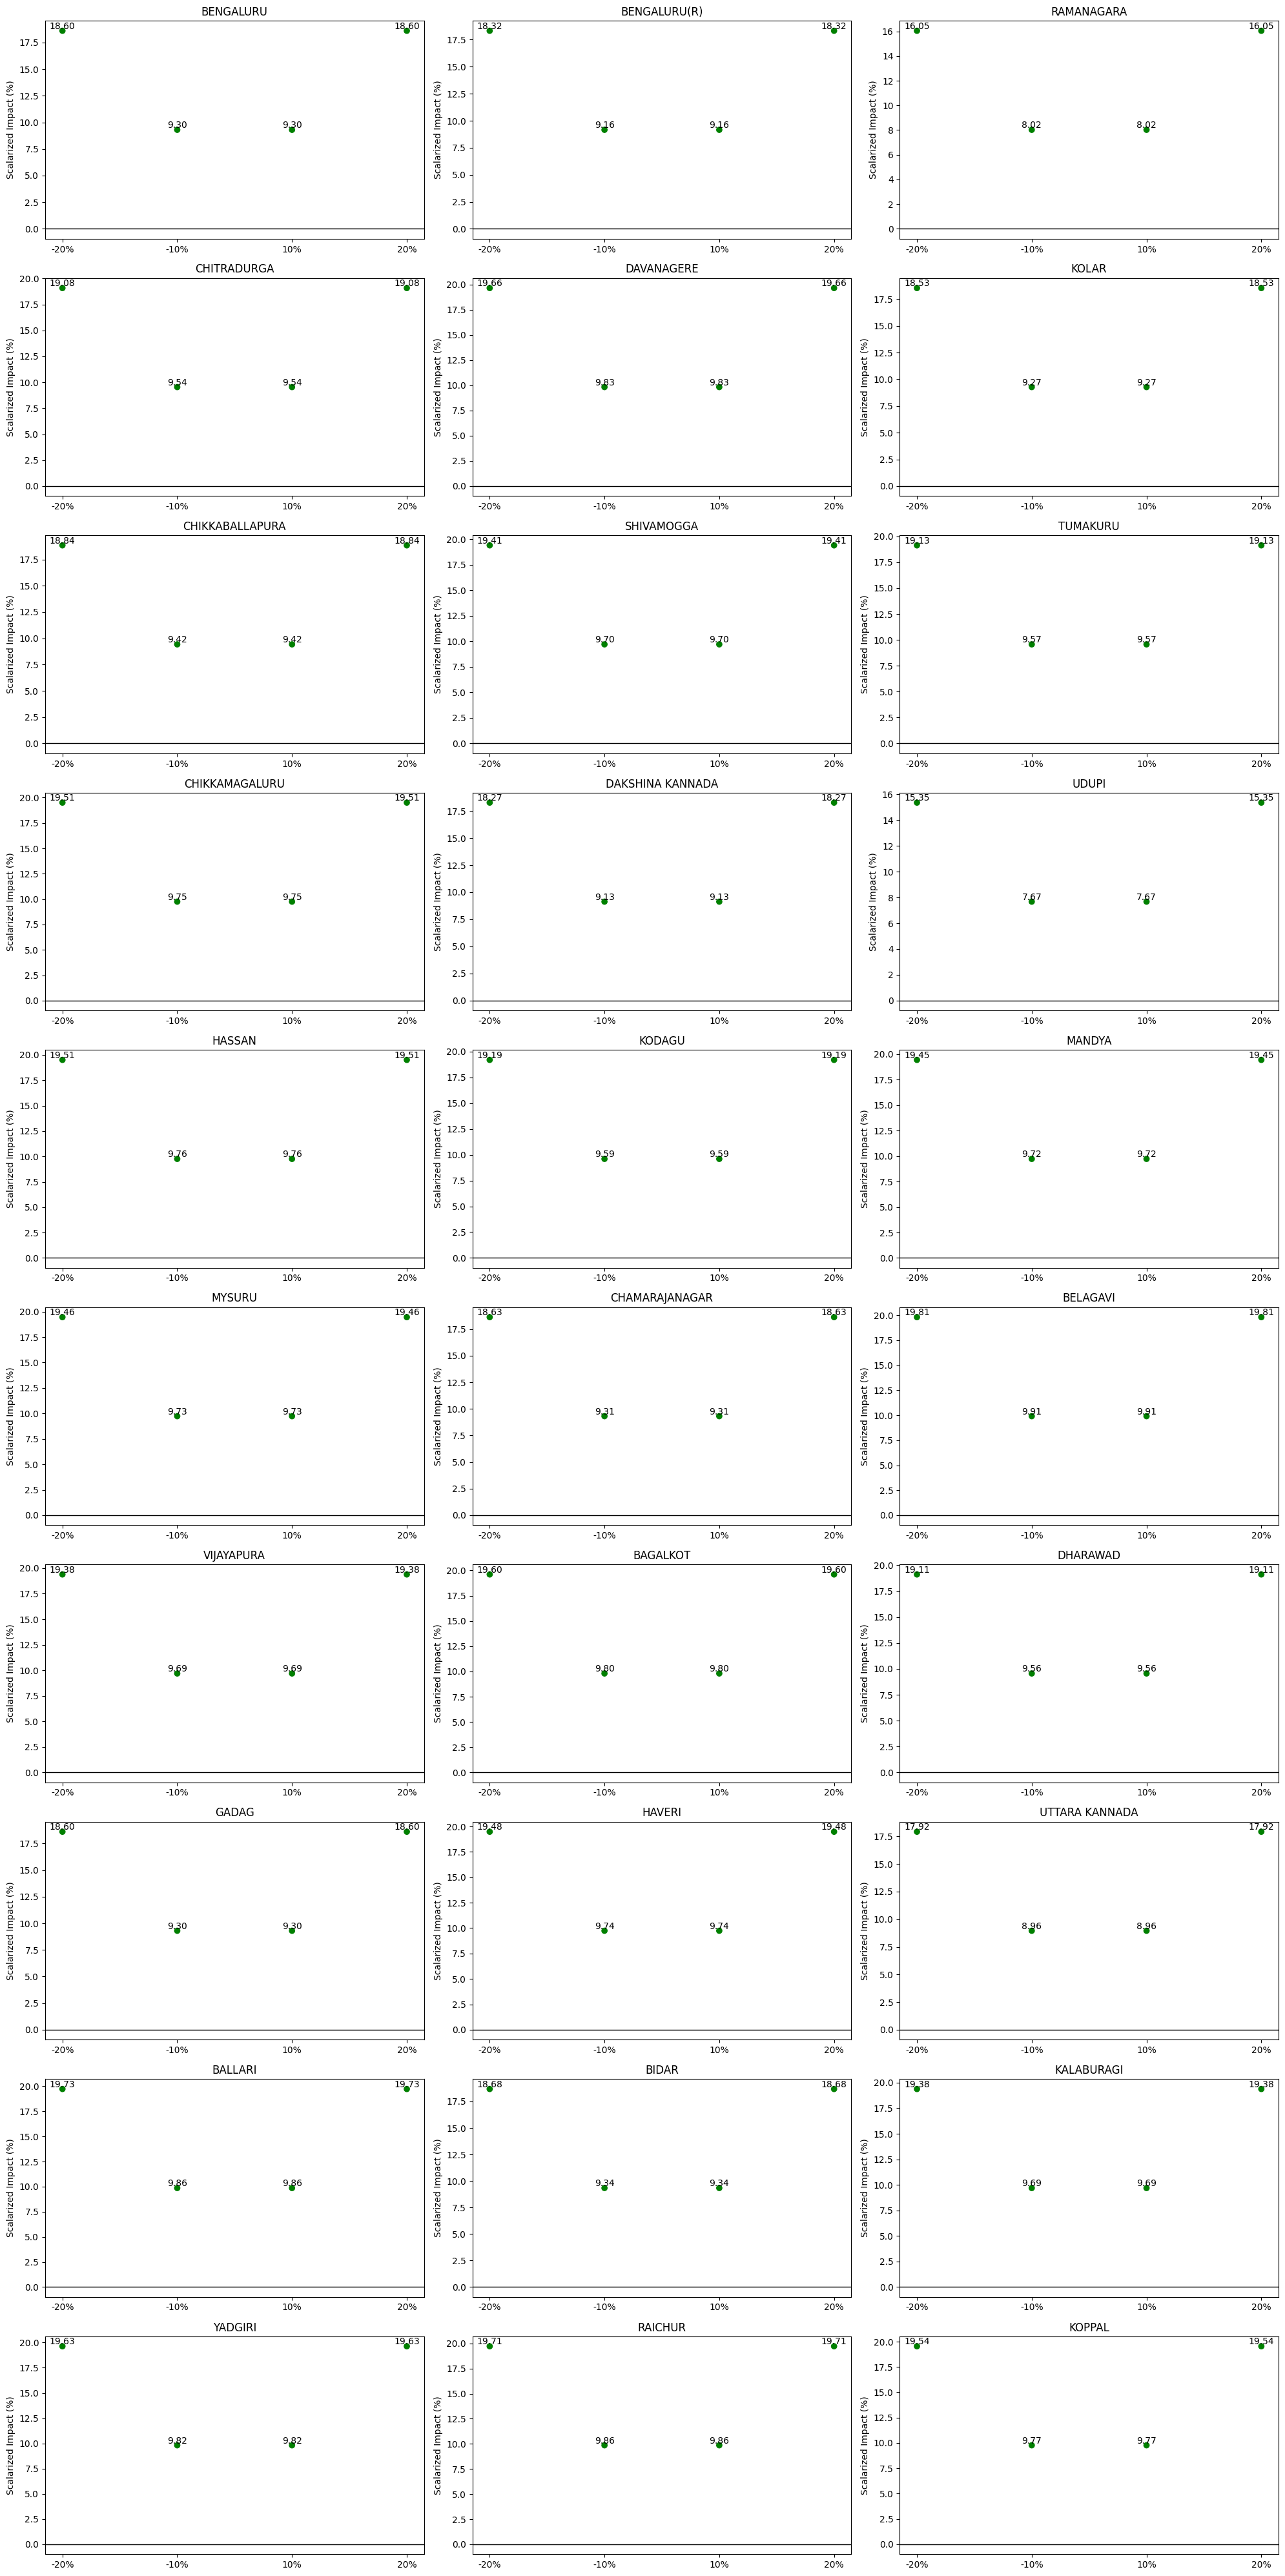

In [41]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

def scalarized_impact_analysis(file_path, factor, Capability_Vector, user_perturbations):
    data = pd.read_csv(file_path)

    # Pre-calculate slopes and intercepts for efficiency
    slopes_intercepts = {}
    for component in Capability_Vector:
        X = sm.add_constant(data[factor])
        y = data[component]
        model = sm.OLS(y, X).fit()
        slopes_intercepts[component] = (model.params[factor], model.params['const'])

    plt.figure(figsize=(20, 40))  # Adjust size as needed

    # Prepare data structure for results
    results = []

    for i, district in enumerate(data['District'].unique(), start=1):
        district_data = data[data['District'] == district]
        district_factor_values = district_data[factor].values

        impacts = []
        for p in user_perturbations:
            perturbation_ratio = p / 100.0
            cv_old, cv_new = [], []

            for component in Capability_Vector:
                slope, intercept = slopes_intercepts[component]
                original_value = slope * district_factor_values + intercept
                new_value = slope * district_factor_values * (1 + perturbation_ratio) + intercept

                cv_old.append(original_value)
                cv_new.append(new_value)

            # Calculate scalarized impact
            change = np.array(cv_new) - np.array(cv_old)
            scalar_impact = np.linalg.norm(change) / np.linalg.norm(cv_old)
            impacts.append(scalar_impact * 100)  # Convert to percentage

        # Plotting
        plt.subplot(10, 3, i)
        positions = np.arange(len(user_perturbations))
        colors = ['red' if x < 0 else 'green' for x in impacts]
        plt.scatter(positions, impacts, c=colors)
        for pos, impact in zip(positions, impacts):
            plt.text(pos, impact, f'{impact:.2f}', ha='center', va='bottom', fontsize=10)  # Increased fontsize here
        plt.xticks(positions, [f'{p}%' for p in user_perturbations])
        plt.title(district)
        plt.ylabel('Scalarized Impact (%)')
        plt.axhline(0, color='black', linewidth=1)

        # Collecting results
        for p, impact in zip(user_perturbations, impacts):
            results.append({'District': district, 'Perturbation (%)': p, 'Scalarized Impact (%)': impact})

    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results)

# Define your parameters
file_path = '/content/Agriculture_KAG_2016_17.csv'  # Update this path
factor = 'TotalNPK'
Capability_Vector = ['Rice_Production', 'Maize_Production', 'Jowar_Yield']
user_perturbations = [-20, -10, 10, 20]

# Perform the analysis and generate plots
results_df = scalarized_impact_analysis(file_path, factor, Capability_Vector, user_perturbations)
